<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=183446848" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=183010840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=182786979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=182712552" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=182257992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Details of Steps can be found on Google Slides via:¶

https://docs.google.com/presentation/d/1sb3QkXiYooHqi3p-tkGVUqwqFKd-601_pzU96W1drw0/edit?usp=sharing

In [ ]:
from kaggle_secrets import UserSecretsClient
wandb_key_label = "WANDB_KEY"
wandb_key= UserSecretsClient().get_secret(wandb_key_label)

In [ ]:
import git
git.Repo.clone_from('https://github.com/Lumin-Lab/BerCuration', '/kaggle/working/scarf')

In [ ]:
!pip install -r /kaggle/working/scarf/requirements.txt

In [1]:
import os
def save_csv_file(df, path):
    dir_name = os.path.dirname(path)
    if dir_name:
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
    df.to_csv(path, index=False)

In [2]:
import pandas as pd
raw_data_path = "/kaggle/input/ber-stratified-samples/BER_stratified_sample.csv"
X_raw = pd.read_csv(raw_data_path)

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1053948496.py:3: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  X_raw = pd.read_csv(raw_data_path)


In [3]:
n_splits = 5
output_dir = "/kaggle/working/output"
config_dir="/kaggle/working/scarf/configs"
scarf_model_name = "scarf"
mlp_model_name = "mlp"

In [4]:
from sklearn.model_selection import KFold
import os
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
for i, (train_index, test_index) in enumerate(kf.split(X_raw)):
    save_csv_file(X_raw.iloc[train_index], f"{output_dir}/split_{i+1}/raw_train.csv")
    save_csv_file(X_raw.iloc[test_index], f"{output_dir}/split_{i+1}/raw_test.csv")

In [5]:
command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "configs" \
      --output_dir="{output_dir}" \
      --data_path={raw_data_path} \
      --output_csv_name "processed" \
      --is_train
    """
os.system(command)

0

In [6]:
files_to_copy = ["column_type_classification.yaml", "encoder.joblib", "scaler.joblib", "train_stats.json"]
for i in range(n_splits):
    for file_name in files_to_copy:
        src = f"{output_dir}/{file_name}"
        dest = f"{output_dir}/split_{i+1}/{file_name}"
        os.system(f"cp {src} {dest}")

In [8]:
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "configs" \
      --output_dir "{output_dir}/split_{i+1}" \
      --data_path "{output_dir}/split_{i+1}/raw_train.csv" \
      --output_csv_name "processed_train" \
    """
    os.system(command)
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "configs" \
      --output_dir "{output_dir}/split_{i+1}" \
      --data_path "{output_dir}/split_{i+1}/raw_test.csv" \
      --output_csv_name "processed_test"
    """
    os.system(command)

**Train the SCARF Encoder on the Train Dataset**

In [11]:
scarf_batch_size = 32
scarf_epochs = 25
scarf_lr = 3e-5
scarf_emb_dim = 32
scarf_encoder_depth = 3
scarf_corruption_rate=0.3

In [12]:
import os
"""The trained scarf model is saved in 
/kaggle/working/output/split_{split}/scarf.pt if you run the following command:
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/run_scarf.py\
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}" \
      --train_data_path="{output_dir}/split_{i+1}/processed_train.csv"\
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name="{scarf_model_name}" \
      --corruption_rate={scarf_corruption_rate} \
      --wandb_project_name='SCARF_Project' \
      --wandb_entity='urbancomp' 
    """

    os.system(command)

wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin

wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin

wandb: wandb version 0.17.1 is available!  To upgrade, please run:

wandb:  $ pip install wandb --upgrade

wandb: Tracking run with wandb version 0.17.0

wandb: Run data is saved locally in /Users/danliu/BerCuration/wandb/run-20240612_213322-xgl2ej0r

wandb: Run `wandb offline` to turn off syncing.

wandb: Syncing run SCARF_Project

wandb: ⭐️ View project at https://wandb.ai/urbancomp/Scarf

wandb: 🚀 View run at https://wandb.ai/urbancomp/Scarf/runs/xgl2ej0r


Epoch [1/25] - Train Loss: 3.010

Model saved at output/split_1/scarf.pt

Epoch [2/25] - Train Loss: 2.926

Model saved at output/split_1/scarf.pt

Epoch [3/25] - Train Loss: 2.866

Model saved at output/split_1/scarf.pt

Epoch [4/25] - Train Loss: 2.957

Epoch [5/25] - Train Loss: 2.884

Epoch [6/25] - Train Loss: 2.919

Epoch [7/25] - Train Loss: 2.896

Epoch [8/25] - Train Loss: 2.849

Model saved at output/split_1/scarf.pt

Epoch [9/25] - Train Loss: 2.942

Epoch [10/25] - Train Loss: 2.856

Epoch [11/25] - Train Loss: 2.905

Epoch [12/25] - Train Loss: 2.846

Model saved at output/split_1/scarf.pt

Epoch [13/25] - Train Loss: 2.819

Model saved at output/split_1/scarf.pt

Epoch [14/25] - Train Loss: 2.837

Epoch [15/25] - Train Loss: 2.808

Model saved at output/split_1/scarf.pt

Epoch [16/25] - Train Loss: 2.938

Epoch [17/25] - Train Loss: 2.915

Epoch [18/25] - Train Loss: 2.866

Epoch [19/25] - Train Loss: 2.887

Epoch [20/25] - Train Loss: 2.949

Epoch [21/25] - Train Loss: 2

wandb: / 0.009 MB of 0.009 MB uploaded

wandb: Run history:

wandb: encoder_train/train_loss █▆▅▃▃▃▃▁▄▂▃▂▃▃▂▃▃▃▃▂▃▂▂▃▂▂▂▅▁▂▂▃▁▃▁▅▂▂▂▂

wandb: 

wandb: Run summary:

wandb: encoder_train/train_loss 3.43504

wandb: 

wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/xgl2ej0r

wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf

wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)

wandb: Find logs at: ./wandb/run-20240612_213322-xgl2ej0r/logs

wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin

wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin

wandb: wandb version 0.17.1 is available!  To upgrade, please run:

wandb:  $ pip install wandb --upgrade

wandb: Tracking run with wandb version 0.17.0

wandb: Run data is saved locally in /Users/danliu/BerCuration/wandb/run-20240612_213900-k6o5fml6

wandb: Run `wandb offline` to turn off syncing.

wandb

Epoch [1/25] - Train Loss: 2.965

Model saved at output/split_2/scarf.pt

Epoch [2/25] - Train Loss: 2.877

Model saved at output/split_2/scarf.pt

Epoch [3/25] - Train Loss: 2.858

Model saved at output/split_2/scarf.pt

Epoch [4/25] - Train Loss: 2.856

Model saved at output/split_2/scarf.pt

Epoch [5/25] - Train Loss: 2.846

Model saved at output/split_2/scarf.pt

Epoch [6/25] - Train Loss: 2.843

Model saved at output/split_2/scarf.pt

Epoch [7/25] - Train Loss: 2.855

Epoch [8/25] - Train Loss: 2.918

Epoch [9/25] - Train Loss: 2.777

Model saved at output/split_2/scarf.pt

Epoch [10/25] - Train Loss: 2.823

Epoch [11/25] - Train Loss: 2.838

Epoch [12/25] - Train Loss: 2.910

Epoch [13/25] - Train Loss: 2.870

Epoch [14/25] - Train Loss: 2.816

Epoch [15/25] - Train Loss: 2.763

Model saved at output/split_2/scarf.pt

Epoch [16/25] - Train Loss: 2.818

Epoch [17/25] - Train Loss: 2.842

Epoch [18/25] - Train Loss: 2.882

Epoch [19/25] - Train Loss: 2.968

Epoch [20/25] - Train Lo

wandb: | 0.009 MB of 0.009 MB uploaded

wandb: Run history:

wandb: encoder_train/train_loss █▆▄▅▄▂▃▃▅▂▂▂▃▄▅▃▃▂▂▃▂▃▂▂▂▂▃▄▂▁▁▃▂▂▂▂▄▂▁▃

wandb: 

wandb: Run summary:

wandb: encoder_train/train_loss 3.39183

wandb: 

wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/k6o5fml6

wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf

wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)

wandb: Find logs at: ./wandb/run-20240612_213900-k6o5fml6/logs

wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin

wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin

wandb: wandb version 0.17.1 is available!  To upgrade, please run:

wandb:  $ pip install wandb --upgrade

wandb: Tracking run with wandb version 0.17.0

wandb: Run data is saved locally in /Users/danliu/BerCuration/wandb/run-20240612_214359-fqw7xjha

wandb: Run `wandb offline` to turn off syncing.

wandb

Epoch [1/25] - Train Loss: 3.031

Model saved at output/split_3/scarf.pt

Epoch [2/25] - Train Loss: 2.878

Model saved at output/split_3/scarf.pt

Epoch [3/25] - Train Loss: 2.909

Epoch [4/25] - Train Loss: 2.838

Model saved at output/split_3/scarf.pt

Epoch [5/25] - Train Loss: 2.842

Epoch [6/25] - Train Loss: 2.988

Epoch [7/25] - Train Loss: 2.850

Epoch [8/25] - Train Loss: 2.856

Epoch [9/25] - Train Loss: 2.875

Epoch [10/25] - Train Loss: 2.844

Epoch [11/25] - Train Loss: 2.935

Epoch [12/25] - Train Loss: 2.755

Model saved at output/split_3/scarf.pt

Epoch [13/25] - Train Loss: 2.852

Epoch [14/25] - Train Loss: 2.893

Epoch [15/25] - Train Loss: 2.879

Epoch [16/25] - Train Loss: 2.828

Epoch [17/25] - Train Loss: 2.779

Epoch [18/25] - Train Loss: 2.830

Epoch [19/25] - Train Loss: 2.864

Epoch [20/25] - Train Loss: 2.841

Epoch [21/25] - Train Loss: 2.803

Epoch [22/25] - Train Loss: 2.834

Epoch [23/25] - Train Loss: 2.804

Epoch [24/25] - Train Loss: 2.842

Epoch [25

wandb: | 0.009 MB of 0.009 MB uploaded

wandb: Run history:

wandb: encoder_train/train_loss █▆▄▇▃▄▆▄▃▂▅▃▂▃▂▄▃▂▃▃▂▂▃▃▁▂▃▃▂▃▁▂▁▂▃▂▂▃▁▃

wandb: 

wandb: Run summary:

wandb: encoder_train/train_loss 3.35383

wandb: 

wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/fqw7xjha

wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf

wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)

wandb: Find logs at: ./wandb/run-20240612_214359-fqw7xjha/logs

wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin

wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin

wandb: wandb version 0.17.1 is available!  To upgrade, please run:

wandb:  $ pip install wandb --upgrade

wandb: Tracking run with wandb version 0.17.0

wandb: Run data is saved locally in /Users/danliu/BerCuration/wandb/run-20240612_214932-d8siiqjo

wandb: Run `wandb offline` to turn off syncing.

wandb

Epoch [1/25] - Train Loss: 2.844

Model saved at output/split_4/scarf.pt

Epoch [2/25] - Train Loss: 2.919

Epoch [3/25] - Train Loss: 2.855

Epoch [4/25] - Train Loss: 2.836

Model saved at output/split_4/scarf.pt

Epoch [5/25] - Train Loss: 2.852

Epoch [6/25] - Train Loss: 2.901

Epoch [7/25] - Train Loss: 2.814

Model saved at output/split_4/scarf.pt

Epoch [8/25] - Train Loss: 2.811

Model saved at output/split_4/scarf.pt

Epoch [9/25] - Train Loss: 2.866

Epoch [10/25] - Train Loss: 2.949

Epoch [11/25] - Train Loss: 2.870

Epoch [12/25] - Train Loss: 2.883

Epoch [13/25] - Train Loss: 2.780

Model saved at output/split_4/scarf.pt

Epoch [14/25] - Train Loss: 2.934

Epoch [15/25] - Train Loss: 2.871

Epoch [16/25] - Train Loss: 2.828

Epoch [17/25] - Train Loss: 2.869

Epoch [18/25] - Train Loss: 2.768

Model saved at output/split_4/scarf.pt

Epoch [19/25] - Train Loss: 2.858

Epoch [20/25] - Train Loss: 2.835

Epoch [21/25] - Train Loss: 2.897

Epoch [22/25] - Train Loss: 2.835


wandb: \ 0.009 MB of 0.009 MB uploaded

wandb: Run history:

wandb: encoder_train/train_loss █▅▄▃▃▃▂▃▄▃▃▂▂▂▄▁▂▁▃▂▁▂▃▃▂▃▂▂▁▂▃▂▃▃▄▃▂▂▂▁

wandb: 

wandb: Run summary:

wandb: encoder_train/train_loss 3.33182

wandb: 

wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/d8siiqjo

wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf

wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)

wandb: Find logs at: ./wandb/run-20240612_214932-d8siiqjo/logs

wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin

wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin

wandb: wandb version 0.17.1 is available!  To upgrade, please run:

wandb:  $ pip install wandb --upgrade

wandb: Tracking run with wandb version 0.17.0

wandb: Run data is saved locally in /Users/danliu/BerCuration/wandb/run-20240612_215519-gp3k29bd

wandb: Run `wandb offline` to turn off syncing.

wandb

Epoch [1/25] - Train Loss: 2.968

Model saved at output/split_5/scarf.pt

Epoch [2/25] - Train Loss: 3.054

Epoch [3/25] - Train Loss: 2.909

Model saved at output/split_5/scarf.pt

Epoch [4/25] - Train Loss: 2.907

Model saved at output/split_5/scarf.pt

Epoch [5/25] - Train Loss: 2.858

Model saved at output/split_5/scarf.pt

Epoch [6/25] - Train Loss: 2.965

Epoch [7/25] - Train Loss: 2.922

Epoch [8/25] - Train Loss: 2.949

Epoch [9/25] - Train Loss: 3.069

Epoch [10/25] - Train Loss: 2.936

Epoch [11/25] - Train Loss: 2.923

Epoch [12/25] - Train Loss: 2.965

Epoch [13/25] - Train Loss: 2.840

Model saved at output/split_5/scarf.pt

Epoch [14/25] - Train Loss: 2.916

Epoch [15/25] - Train Loss: 2.916

Epoch [16/25] - Train Loss: 2.853

Epoch [17/25] - Train Loss: 2.837

Model saved at output/split_5/scarf.pt

Epoch [18/25] - Train Loss: 2.935

Epoch [19/25] - Train Loss: 2.840

Epoch [20/25] - Train Loss: 2.906

Epoch [21/25] - Train Loss: 2.869

Epoch [22/25] - Train Loss: 2.835


wandb: / 0.009 MB of 0.009 MB uploaded

wandb: Run history:

wandb: encoder_train/train_loss █▆▅▅▅▃▃▃▃▂▂▂▃▃▃▃▃▂▃▂▂▂▂▃▃▁▃▃▁▂▁▁▂▂▂▃▄▂▃▂

wandb: 

wandb: Run summary:

wandb: encoder_train/train_loss 3.38509

wandb: 

wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/gp3k29bd

wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf

wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)

wandb: Find logs at: ./wandb/run-20240612_215519-gp3k29bd/logs


**Obtain the SCARF embeddings for different train splits, and save the result**

In [14]:
"""The generated embeddings are saved as a NumPy array in 
/kaggle/working/output/split_{split}/train.npy if you run the following command:
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_scarf_embedding.py \
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}" \
      --data_path="{output_dir}/split_{i+1}/processed_train.csv" \
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name={scarf_model_name} \
      --corruption_rate={scarf_corruption_rate} \
      --embedding_save_name="train"
    """

    os.system(command)

Model loaded from output/split_1/scarf.pt

Model loaded from output/split_2/scarf.pt

Model loaded from output/split_3/scarf.pt

Model loaded from output/split_4/scarf.pt

Model loaded from output/split_5/scarf.pt


**Obtain the SCARF embeddings for different test splits, and save the result**

In [15]:
"""The generated embeddings are saved as a NumPy array in 
/kaggle/working/output/split_{split}/test.npy if you run the following command:
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_scarf_embedding.py\
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}" \
      --data_path="{output_dir}/split_{i+1}/processed_test.csv" \
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name={scarf_model_name} \
      --corruption_rate={scarf_corruption_rate} \
      --embedding_save_name="test"
    """

    os.system(command)

Model loaded from output/split_1/scarf.pt

Model loaded from output/split_2/scarf.pt

Model loaded from output/split_3/scarf.pt

Model loaded from output/split_4/scarf.pt

Model loaded from output/split_5/scarf.pt


In [16]:
command = f"""
    python /kaggle/working/scarf/get_scarf_embedding.py \
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_1" \
      --data_path="{output_dir}/processed.csv" \
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name={scarf_model_name} \
      --corruption_rate={scarf_corruption_rate} \
      --embedding_save_name="all_emb"
    """

os.system(command)

Model loaded from output/split_1/scarf.pt


0

**Random Forest**

In [17]:
from sklearn.ensemble import RandomForestClassifier
max_depth = 6
def get_rf(max_depth=max_depth):
    return RandomForestClassifier(max_depth=max_depth, random_state=42)

**Original Data**

In [18]:
import numpy as np
processed = pd.read_csv(f"{output_dir}/processed.csv")
all_emb = np.load(f"{output_dir}/split_1/all_emb.npy")

In [7]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_predict
from cleanlab import Datalab
from sklearn.metrics import f1_score

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  from .autonotebook import tqdm as notebook_tqdm


In [20]:
X_processed = processed.drop(columns=["EnergyRating"])
labels = processed['EnergyRating']
clf = get_rf()
pred_probs = cross_val_predict(
    clf,
    X_processed,
    labels,
    cv=kf,
    method="predict_proba",
)
KNN = NearestNeighbors(metric='euclidean')
KNN.fit(X_processed.values)

knn_graph = KNN.kneighbors_graph(mode="distance")
data = {"X": X_processed.values, "y": labels}

lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, knn_graph=knn_graph)

display(lab.report())


Finding label issues ...

Finding outlier issues ...

Finding near_duplicate issues ...

Finding non_iid issues ...

Finding class_imbalance issues ...

Finding underperforming_group issues ...


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neighbors/_base.py:246: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.

  warnings.warn(




Audit complete. 65485 issues found in the dataset.

Here is a summary of the different kinds of issues found in the data:



    issue_type  num_issues

         label       54404

near_duplicate        8785

       outlier        2296



Dataset Information: num_examples: 121184, num_classes: 15





----------------------- label issues -----------------------



About this issue:

	Examples whose given label is estimated to be potentially incorrect

    (e.g. due to annotation error) are flagged as having label issues.

    



Number of examples with this issue: 54404

Overall dataset quality in terms of this issue: 0.5692



Examples representing most severe instances of this issue:

        is_label_issue  label_score  given_label  predicted_label

24816             True     0.002421            0                7

12524             True     0.003933            0                2

47324             True     0.004457            1                6

67446             True     0.0081

None

In [21]:
# Label Issues
label_issues_num =  54404
outlier_nums = 2296
duplicates_nums = 8785

issue_results = lab.get_issues("label")
sorted_issues = issue_results.sort_values("label_score").index

sorted_issues_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_issues, "Unnamed: 0"]
})
save_csv_file(sorted_issues_df[:label_issues_num], f"{output_dir}/random_forest/data/label_issues.csv")
print(len(sorted_issues_df))

print("Label Issues")
display(X_raw.iloc[sorted_issues].assign(
    given_label=labels.iloc[sorted_issues],
    predicted_label=issue_results["predicted_label"].iloc[sorted_issues]
).head())

# Outliers
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index
print("Outliers")
display(X_raw.iloc[sorted_outliers].head())

sorted_outliers_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_outliers[:outlier_nums], "Unnamed: 0"]
})
print(len(sorted_outliers_df))
save_csv_file(sorted_outliers_df, f"{output_dir}/random_forest/data/outliers.csv")


# Near-duplicate issues
duplicate_results = lab.get_issues("near_duplicate")
sorted_duplicates = duplicate_results.sort_values("near_duplicate_score").index
print("Near-duplicate issues")
display(duplicate_results.sort_values("near_duplicate_score").head())
sorted_duplicates_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_duplicates, "Unnamed: 0"]
})
print(len(sorted_duplicates_df))
save_csv_file(sorted_duplicates_df[:duplicates_nums], f"{output_dir}/random_forest/data/duplicates.csv")


121184

Label Issues


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC,given_label,predicted_label
24816,752940,Co. Galway,Semi-detached house,2001,Existing,A1,-21.61,65.64,0.55,0.13,...,067057011,0.050000,0.050000,1.143,12712.3,15487.50,0.507,-0.108,0,7
12524,117187,Co. Donegal,Detached house,2009,Final,A1,3.89,173.57,0.13,0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.188,0.022,0,2
47324,648381,Dublin 11,Mid-terrace house,1976,Existing,A2,46.82,87.24,0.42,0.17,...,268030005,0.000222,0.012347,0.692,10529.0,8716.96,0.539,0.293,1,6
67446,644247,Co. Carlow,Semi-detached house,1987,Existing,A2,33.48,70.00,0.37,0.20,...,17045001,0.050000,0.050000,0.847,10998.2,9948.62,0.618,0.180,1,6
118391,720950,Co. Dublin,Semi-detached house,2005,Existing,A2,44.07,126.78,0.33,0.25,...,267104016,0.000222,0.012347,0.626,13667.8,9140.68,0.304,0.307,1,5


Outliers


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
99966,912339,Co. Galway,Detached house,1905,Existing,G,842.25,88.56,1.99,1.44,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,654970,Co. Louth,Detached house,2013,Provisional,A2,48.08,984.23,0.16,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,0.360
54221,1137153,Dublin 18,Detached house,1944,Existing,E1,311.70,510.65,2.10,2.30,...,NaN,NaN,267090003,0.050000,0.050000,0.0,155887.0,0.0,1.834,1.794
94225,331,Co. Kildare,Detached house,1943,Existing,G,481.80,71.00,2.16,0.13,...,NaN,NaN,87068001,0.089325,0.089325,NaN,NaN,NaN,NaN,NaN
3329,128742,Co. Laois,Mid-terrace house,1960,Existing,G,989.35,138.82,2.10,2.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2296

Near-duplicate issues


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
12099,True,0.0,"[110211, 12058, 46803]",0.0
112559,True,0.0,"[91855, 9294, 111114]",0.0
35912,True,0.0,"[103010, 107006, 56622, 60273]",0.0
17828,True,0.0,[78162],0.0
92173,True,0.0,[6277],0.0


121184


**Before Removal**

In [98]:
results = []

for i in range(n_splits):
    clf = get_rf()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    clf.fit(train_df.drop(columns=["EnergyRating"]), train_df["EnergyRating"])
    acc = clf.score(test_df.drop(columns=["EnergyRating"]), test_df["EnergyRating"])
    predict = clf.predict(test_df.drop(columns=["EnergyRating"]))
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")
    results.append({"Split": i+1, "Accuracy": acc, "F1 Score": f1})

# Save the results to a CSV file
results_df = pd.DataFrame(results)
save_csv_file(results_df, f"{output_dir}/random_forest/data/results_after_removal.csv")
    

Split: 1, Accuracy: 0.3899822585303462, F1 Score: 0.2621519857476223

Split: 2, Accuracy: 0.39055988777488965, F1 Score: 0.26388923086436034

Split: 3, Accuracy: 0.38560877996451703, F1 Score: 0.2624692801808928

Split: 4, Accuracy: 0.3848248545612081, F1 Score: 0.26380871586820714

Split: 5, Accuracy: 0.3888017824723552, F1 Score: 0.2648734931973145


After Removal

In [119]:
for i in range(n_splits):
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
    label_issue_index = pd.read_csv(f"{output_dir}/random_forest/data/label_issues.csv")
    train_df_removed = train_df[~train_df["Unnamed: 0"].isin(label_issue_index["Unnamed: 0"])]
    print(len(train_df_removed), len(train_df_removed)/len(train_df))
    save_csv_file(train_df_removed, f"{output_dir}/split_{i+1}/train_removed.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_9332/726970534.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


53596 0.5528381486791752


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_9332/726970534.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


53364 0.5504450885535396


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_9332/726970534.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


53332 0.5501150112948312


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_9332/726970534.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


53521 0.5520645301040775


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_9332/726970534.py:2: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


53307 0.5498514667656889


In [120]:
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "configs" \
      --output_dir "{output_dir}/split_{i+1}" \
      --data_path "{output_dir}/split_{i+1}/train_removed.csv" \
      --output_csv_name "processed_train_removed" \
    """
    os.system(command)

In [121]:
results = []

for i in range(n_splits):
    clf = get_rf()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train_removed.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    clf.fit(train_df.drop(columns=["EnergyRating"]), train_df["EnergyRating"])
    acc = clf.score(test_df.drop(columns=["EnergyRating"]), test_df["EnergyRating"])
    predict = clf.predict(test_df.drop(columns=["EnergyRating"]))
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")
    results.append({"Split": i+1, "Accuracy": acc, "F1 Score": f1})

# Save the results to a CSV file
results_df = pd.DataFrame(results)
save_csv_file(results_df, f"{output_dir}/random_forest/data/results_after_removal.csv")

Split: 1, Accuracy: 0.34026488426785495, F1 Score: 0.209657847394551

Split: 2, Accuracy: 0.34018236580434874, F1 Score: 0.2074143513773932

Split: 3, Accuracy: 0.3407599950488922, F1 Score: 0.21504912946388355

Split: 4, Accuracy: 0.33745925650864383, F1 Score: 0.20979755756931687

Split: 5, Accuracy: 0.33598778676349234, F1 Score: 0.20831624863229933


**Scarf Embedding**

In [23]:

X_processed = pd.DataFrame(all_emb, columns=[f"feature_{i+1}" for i in range(all_emb.shape[1])])
labels = processed['EnergyRating']
clf = get_rf()
pred_probs = cross_val_predict(
    clf,
    X_processed,
    labels,
    cv=kf,
    method="predict_proba",
)
KNN = NearestNeighbors(metric='euclidean')
KNN.fit(X_processed.values)

knn_graph = KNN.kneighbors_graph(mode="distance")
data = {"X": X_processed.values, "y": labels}

lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, knn_graph=knn_graph)
display(lab.report())

Here is a summary of the different kinds of issues found in the data:



           issue_type  num_issues

                label       52164

       near_duplicate        7983

              outlier        3752

underperforming_group           5



Dataset Information: num_examples: 121184, num_classes: 15





----------------------- label issues -----------------------



About this issue:

	Examples whose given label is estimated to be potentially incorrect

    (e.g. due to annotation error) are flagged as having label issues.

    



Number of examples with this issue: 52164

Overall dataset quality in terms of this issue: 0.4814



Examples representing most severe instances of this issue:

        is_label_issue  label_score  given_label  predicted_label

24816            False     0.000014            0                7

22021             True     0.000625            2                8

111046            True     0.000842            2               10

67446             True  

None

In [24]:
# Label Issues
label_issues_num =  52164
outlier_nums = 3752
duplicates_nums = 7983

issue_results = lab.get_issues("label")
sorted_issues = issue_results.sort_values("label_score").index

sorted_issues_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_issues, "Unnamed: 0"]
})
save_csv_file(sorted_issues_df[:label_issues_num], f"{output_dir}/random_forest/emb/label_issues.csv")
print(len(sorted_issues_df))

print("Label Issues")
display(X_raw.iloc[sorted_issues].assign(
    given_label=labels.iloc[sorted_issues],
    predicted_label=issue_results["predicted_label"].iloc[sorted_issues]
).head())

# Outliers
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index
print("Outliers")
display(X_raw.iloc[sorted_outliers].head())

sorted_outliers_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_outliers[:outlier_nums], "Unnamed: 0"]
})
print(len(sorted_outliers_df))
save_csv_file(sorted_outliers_df, f"{output_dir}/random_forest/emb/outliers.csv")


# Near-duplicate issues
duplicate_results = lab.get_issues("near_duplicate")
sorted_duplicates = duplicate_results.sort_values("near_duplicate_score").index
print("Near-duplicate issues")
display(duplicate_results.sort_values("near_duplicate_score").head())
sorted_duplicates_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_duplicates, "Unnamed: 0"]
})
print(len(sorted_duplicates_df))
save_csv_file(sorted_duplicates_df[:duplicates_nums], f"{output_dir}/random_forest/emb/duplicates.csv")


121184

Label Issues


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC,given_label,predicted_label
24816,752940,Co. Galway,Semi-detached house,2001,Existing,A1,-21.61,65.64,0.55,0.13,...,067057011,0.0500,0.0500,1.143,12712.30,15487.50,0.507,-0.108,0,7
22021,567580,Dublin 24,Mid-terrace house,1968,Existing,A3,61.56,89.77,0.71,0.23,...,267136003,0.0500,0.0500,0.641,13445.40,9850.52,0.551,0.406,2,8
111046,481391,Dublin 6,Mid-floor apartment,1900,Existing,A3,57.66,17.59,0.25,0.00,...,268132014,0.0500,0.0500,0.396,1558.85,1021.80,0.172,0.170,2,10
67446,644247,Co. Carlow,Semi-detached house,1987,Existing,A2,33.48,70.00,0.37,0.20,...,17045001,0.0500,0.0500,0.847,10998.20,9948.62,0.618,0.180,1,6
97402,1191541,Dublin 2,Mid-floor apartment,1993,Existing,A3,73.17,65.98,0.60,0.00,...,268140012,0.0025,0.0025,NaN,NaN,NaN,NaN,NaN,2,9


Outliers


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
99966,912339,Co. Galway,Detached house,1905,Existing,G,842.25,88.56,1.99,1.44,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,654970,Co. Louth,Detached house,2013,Provisional,A2,48.08,984.23,0.16,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,0.360
94225,331,Co. Kildare,Detached house,1943,Existing,G,481.80,71.00,2.16,0.13,...,NaN,NaN,87068001,0.089325,0.089325,NaN,NaN,NaN,NaN,NaN
110292,227162,Co. Wicklow,Detached house,1970,Existing,D2,262.02,860.31,2.05,2.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54221,1137153,Dublin 18,Detached house,1944,Existing,E1,311.70,510.65,2.10,2.30,...,NaN,NaN,267090003,0.050000,0.050000,0.0,155887.0,0.0,1.834,1.794


3752

Near-duplicate issues


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
6135,True,0.0,"[52217, 62841]",0.0
50240,True,0.0,[31167],0.0
20361,True,0.0,[62627],0.0
113828,True,0.0,"[24650, 15881]",0.0
55070,True,0.0,"[20557, 59616, 78290, 70375, 99800]",0.0


121184


**Before Removal**

In [25]:
results = []

for i in range(n_splits):
    clf = get_rf()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    train_X = np.load(f"{output_dir}/split_{i+1}/train.npy")
    test_X = np.load(f"{output_dir}/split_{i+1}/test.npy")
    clf.fit(train_X, train_df["EnergyRating"])
    acc = clf.score(test_X, test_df["EnergyRating"],
             )
    predict = clf.predict(test_X)
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")
    results.append({"Split": i+1, "Accuracy": acc, "F1 Score": f1})

# Save the results to a CSV file
results_df = pd.DataFrame(results)
save_csv_file(results_df, f"{output_dir}/random_forest/emb/results_before_removal.csv")

Split: 1, Accuracy: 0.40599084045055084, F1 Score: 0.3115355886017209

Split: 2, Accuracy: 0.39221025704501383, F1 Score: 0.29794016573026844

Split: 3, Accuracy: 0.38721789000288814, F1 Score: 0.29548171277174323

Split: 4, Accuracy: 0.399760696455832, F1 Score: 0.3114484668830467

Split: 5, Accuracy: 0.3998597128238983, F1 Score: 0.3084068187120861


**After Removal**

In [23]:
original_rating_encoding = {
    "A1": 0,
    "A2": 1,
    "A3": 2,
    "B1": 3,
    "B2": 4,
    "B3": 5,
    "C1": 6,
    "C2": 7,
    "C3": 8,
    "D1": 9,
    "D2": 10,
    "E1": 11,
    "E2": 12,
    "F": 13,
    "G": 14
}

In [41]:
for i in range(n_splits):
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
    train_X = np.load(f"{output_dir}/split_{i+1}/train.npy")
    
    label_issue_index = pd.read_csv(f"{output_dir}/random_forest/emb/label_issues.csv")
    train_df_removed = train_df[~train_df["Unnamed: 0"].isin(label_issue_index["Unnamed: 0"])]
    train_X_removed = train_X[train_df_removed.index]
    train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()
    train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].map(original_rating_encoding)
    print(len(train_df_removed), len(train_df_removed)/len(train_df))
    save_csv_file(train_df_removed, f"{output_dir}/split_{i+1}/train_removed.csv")
    np.save(f"{output_dir}/split_{i+1}/train_removed.npy", train_X_removed)

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https:/

55250 0.569899016988664


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https:/

55305 0.570466337277069


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https:/

55135 0.5687128018401807


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https:/

55186 0.5692388624712472


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:2: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/2867342498.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pan

55204 0.5694186574245987


In [43]:
results = []

for i in range(n_splits):
    clf = get_rf()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    train_X = np.load(f"{output_dir}/split_{i+1}//train_removed.npy")
    test_X = np.load(f"{output_dir}/split_{i+1}/test.npy")
    clf.fit(train_X, train_df["EnergyRating"])
    acc = clf.score(test_X, test_df["EnergyRating"],
             )
    predict = clf.predict(test_X)
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")
    results.append({"Split": i+1, "Accuracy": acc, "F1 Score": f1})
results_df = pd.DataFrame(results)
save_csv_file(results_df, f"{output_dir}/random_forest/emb/results_after_removal.csv")



/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/3560689056.py:5: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")


Split: 1, Accuracy: 0.39344803399760697, F1 Score: 0.29268993755968037


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/3560689056.py:5: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")


Split: 2, Accuracy: 0.38465981763419566, F1 Score: 0.2840635677192032


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/3560689056.py:5: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")


Split: 3, Accuracy: 0.3817304121797252, F1 Score: 0.2833222772236175


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/3560689056.py:5: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")


Split: 4, Accuracy: 0.3913438131781986, F1 Score: 0.2949130698215116


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_25332/3560689056.py:5: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")


Split: 5, Accuracy: 0.3849645155966331, F1 Score: 0.2892019961398793


**MLP**

In [5]:
from sklearn.neural_network import MLPClassifier
hidden_layer_sizes = [256 , 128 , 64 , 32 , 16]
max_iter = 25
batch_size = 32
def get_mlp(hidden_layer_sizes=hidden_layer_sizes,
           max_iter= max_iter,
           batch_size = batch_size):
    return MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        random_state= 42,
                        max_iter= max_iter,
                        batch_size = batch_size)

In [45]:
X_processed = processed.drop(columns=["EnergyRating"])
labels = processed['EnergyRating']
clf = get_mlp()
pred_probs = cross_val_predict(
    clf,
    X_processed,
    labels,
    cv=kf,
    method="predict_proba",
)
KNN = NearestNeighbors(metric='euclidean')
KNN.fit(X_processed.values)

knn_graph = KNN.kneighbors_graph(mode="distance")
data = {"X": X_processed.values, "y": labels}

lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, knn_graph=knn_graph)

display(lab.report())

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

Finding label issues ...

Finding outlier issues ...

Finding near_duplicate issues ...

Finding non_iid issues ...

Finding class_imbalance issues ...

Finding underperforming_group issues ...


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neighbors/_base.py:246: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.

  warnings.warn(




Audit complete. 48020 issues found in the dataset.

Here is a summary of the different kinds of issues found in the data:



    issue_type  num_issues

         label       36939

near_duplicate        8785

       outlier        2296



Dataset Information: num_examples: 121184, num_classes: 15





----------------------- label issues -----------------------



About this issue:

	Examples whose given label is estimated to be potentially incorrect

    (e.g. due to annotation error) are flagged as having label issues.

    



Number of examples with this issue: 36939

Overall dataset quality in terms of this issue: 0.7307



Examples representing most severe instances of this issue:

        is_label_issue   label_score  given_label  predicted_label

19966             True  1.839350e-13            0                7

11116             True  1.368927e-12            9               14

114825            True  4.118713e-12            0                6

40824             True  9.322

None

**Original Data**

In [46]:
# Label Issues
label_issues_num =  36939
outlier_nums = 2296
duplicates_nums = 8785

issue_results = lab.get_issues("label")
sorted_issues = issue_results.sort_values("label_score").index

sorted_issues_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_issues, "Unnamed: 0"]
})
save_csv_file(sorted_issues_df[:label_issues_num], f"{output_dir}/mlp/data/label_issues.csv")
print(len(sorted_issues_df))

print("Label Issues")
display(X_raw.iloc[sorted_issues].assign(
    given_label=labels.iloc[sorted_issues],
    predicted_label=issue_results["predicted_label"].iloc[sorted_issues]
).head())

# Outliers
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index
print("Outliers")
display(X_raw.iloc[sorted_outliers].head())

sorted_outliers_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_outliers[:outlier_nums], "Unnamed: 0"]
})
print(len(sorted_outliers_df))
save_csv_file(sorted_outliers_df, f"{output_dir}/mlp/data/outliers.csv")


# Near-duplicate issues
duplicate_results = lab.get_issues("near_duplicate")
sorted_duplicates = duplicate_results.sort_values("near_duplicate_score").index
print("Near-duplicate issues")
display(duplicate_results.sort_values("near_duplicate_score").head())
sorted_duplicates_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_duplicates, "Unnamed: 0"]
})
print(len(sorted_duplicates_df))
save_csv_file(sorted_duplicates_df[:duplicates_nums], f"{output_dir}/mlp/data/duplicates.csv")


121184

Label Issues


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC,given_label,predicted_label
19966,759261,Co. Roscommon,Detached house,1965,Existing,A1,4.93,108.99,1.24,0.26,...,197093002,8.830924e-02,0.088309,1.071,233.285,26998.9,-0.051,0.027,0,7
11116,781412,Dublin 10,Mid-terrace house,1940,Existing,D1,246.61,66.74,2.10,2.30,...,268057005,5.562300e-07,0.002500,NaN,NaN,NaN,NaN,NaN,9,14
114825,761719,Co. Mayo,Detached house,1900,Existing,A1,-4.06,84.54,0.36,0.28,...,157106003,5.000000e-02,0.050000,1.032,0.000,11020.6,-0.015,-0.023,0,6
40824,946507,Co. Wexford,Mid-terrace house,1981,Existing,F,405.45,89.58,0.95,0.16,...,247045025,5.562300e-07,0.002500,NaN,NaN,NaN,NaN,NaN,13,9
97402,1191541,Dublin 2,Mid-floor apartment,1993,Existing,A3,73.17,65.98,0.60,0.00,...,268140012,2.500000e-03,0.002500,NaN,NaN,NaN,NaN,NaN,2,9


Outliers


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
99966,912339,Co. Galway,Detached house,1905,Existing,G,842.25,88.56,1.99,1.44,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,654970,Co. Louth,Detached house,2013,Provisional,A2,48.08,984.23,0.16,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,0.360
54221,1137153,Dublin 18,Detached house,1944,Existing,E1,311.70,510.65,2.10,2.30,...,NaN,NaN,267090003,0.050000,0.050000,0.0,155887.0,0.0,1.834,1.794
94225,331,Co. Kildare,Detached house,1943,Existing,G,481.80,71.00,2.16,0.13,...,NaN,NaN,87068001,0.089325,0.089325,NaN,NaN,NaN,NaN,NaN
3329,128742,Co. Laois,Mid-terrace house,1960,Existing,G,989.35,138.82,2.10,2.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


2296

Near-duplicate issues


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
12099,True,0.0,"[110211, 12058, 46803]",0.0
112559,True,0.0,"[91855, 9294, 111114]",0.0
35912,True,0.0,"[103010, 107006, 56622, 60273]",0.0
17828,True,0.0,[78162],0.0
92173,True,0.0,[6277],0.0


121184


**Before Removal**

In [8]:
results = []

for i in range(n_splits):
    clf = get_mlp()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    clf.fit(train_df.drop(columns=["EnergyRating"]), train_df["EnergyRating"])
    acc = clf.score(test_df.drop(columns=["EnergyRating"]), test_df["EnergyRating"])
    predict = clf.predict(test_df.drop(columns=["EnergyRating"]))
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")
    results.append({"Split": i+1, "Accuracy": acc, "F1 Score": f1})

# Save the results to a CSV file
results_df = pd.DataFrame(results)
save_csv_file(results_df, f"{output_dir}/mlp/data/results_before_removal.csv")

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 1, Accuracy: 0.6253249164500557, F1 Score: 0.5967502481040132


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 2, Accuracy: 0.6292445434666006, F1 Score: 0.6028769932172827


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 3, Accuracy: 0.6299459504064034, F1 Score: 0.5896643430499089


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 4, Accuracy: 0.6367124644139126, F1 Score: 0.6061228132525307


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 5, Accuracy: 0.6155306156131375, F1 Score: 0.5871133053329303


**After Removal**

In [9]:
for i in range(n_splits):
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
    label_issue_index = pd.read_csv(f"{output_dir}/mlp/data/label_issues.csv")
    train_df_removed = train_df[~train_df["Unnamed: 0"].isin(label_issue_index["Unnamed: 0"])]
    print(len(train_df_removed), len(train_df_removed)/len(train_df))
    save_csv_file(train_df_removed, f"{output_dir}/split_{i+1}/train_removed.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/2653796351.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


67310 0.6942968838643795


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/2653796351.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


67394 0.695163336668489


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/2653796351.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


67319 0.6943897180933912


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/2653796351.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


67253 0.6937089337473052


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/2653796351.py:2: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")


67704 0.6983537566530511


In [10]:
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "configs" \
      --output_dir "{output_dir}/split_{i+1}" \
      --data_path "{output_dir}/split_{i+1}/train_removed.csv" \
      --output_csv_name "processed_train_removed" \
    """
    os.system(command)

In [11]:
results = []

for i in range(n_splits):
    clf = get_mlp()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train_removed.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    clf.fit(train_df.drop(columns=["EnergyRating"]), train_df["EnergyRating"])
    acc = clf.score(test_df.drop(columns=["EnergyRating"]), test_df["EnergyRating"])
    predict = clf.predict(test_df.drop(columns=["EnergyRating"]))
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")
    results.append({"Split": i+1, "Accuracy": acc, "F1 Score": f1})

# Save the results to a CSV file
results_df = pd.DataFrame(results)
save_csv_file(results_df, f"{output_dir}/mlp/data/results_after_removal.csv")

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 1, Accuracy: 0.6459957915583612, F1 Score: 0.6095391062264698


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 2, Accuracy: 0.6470272723521888, F1 Score: 0.6038907204782586


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 3, Accuracy: 0.648677641622313, F1 Score: 0.6096907508889404


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 4, Accuracy: 0.6501629739654248, F1 Score: 0.6052608388098875


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 5, Accuracy: 0.6384716949991748, F1 Score: 0.6035612219373274


**Scarf Embedding**

In [19]:

X_processed = pd.DataFrame(all_emb, columns=[f"feature_{i+1}" for i in range(all_emb.shape[1])])
labels = processed['EnergyRating']
clf = get_mlp()
pred_probs = cross_val_predict(
    clf,
    X_processed,
    labels,
    cv=kf,
    method="predict_proba",
)
KNN = NearestNeighbors(metric='euclidean')
KNN.fit(X_processed.values)

knn_graph = KNN.kneighbors_graph(mode="distance")
data = {"X": X_processed.values, "y": labels}

lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, knn_graph=knn_graph)
display(lab.report())

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

Finding label issues ...

Finding outlier issues ...

Finding near_duplicate issues ...

Finding non_iid issues ...

Finding class_imbalance issues ...

Finding underperforming_group issues ...


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neighbors/_base.py:246: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.

  warnings.warn(




Audit complete. 60625 issues found in the dataset.

Here is a summary of the different kinds of issues found in the data:



    issue_type  num_issues

         label       48890

near_duplicate        7983

       outlier        3752



Dataset Information: num_examples: 121184, num_classes: 15





----------------------- label issues -----------------------



About this issue:

	Examples whose given label is estimated to be potentially incorrect

    (e.g. due to annotation error) are flagged as having label issues.

    



Number of examples with this issue: 48890

Overall dataset quality in terms of this issue: 0.5797



Examples representing most severe instances of this issue:

        is_label_issue   label_score  given_label  predicted_label

86717             True  5.693595e-09            9               14

24816             True  4.068693e-08            0                9

40824             True  6.380232e-07           13                8

109382            True  1.386

None

In [20]:
# Label Issues
label_issues_num =  48890
outlier_nums =  3752
duplicates_nums = 7983

issue_results = lab.get_issues("label")
sorted_issues = issue_results.sort_values("label_score").index

sorted_issues_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_issues, "Unnamed: 0"]
})
save_csv_file(sorted_issues_df[:label_issues_num], f"{output_dir}/mlp/emb/label_issues.csv")
print(len(sorted_issues_df))

print("Label Issues")
display(X_raw.iloc[sorted_issues].assign(
    given_label=labels.iloc[sorted_issues],
    predicted_label=issue_results["predicted_label"].iloc[sorted_issues]
).head())

# Outliers
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index
print("Outliers")
display(X_raw.iloc[sorted_outliers].head())

sorted_outliers_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_outliers[:outlier_nums], "Unnamed: 0"]
})
print(len(sorted_outliers_df))
save_csv_file(sorted_outliers_df, f"{output_dir}/mlp/emb/outliers.csv")


# Near-duplicate issues
duplicate_results = lab.get_issues("near_duplicate")
sorted_duplicates = duplicate_results.sort_values("near_duplicate_score").index
print("Near-duplicate issues")
display(duplicate_results.sort_values("near_duplicate_score").head())
sorted_duplicates_df = pd.DataFrame({
    "Unnamed: 0": X_raw.loc[sorted_duplicates, "Unnamed: 0"]
})
print(len(sorted_duplicates_df))
save_csv_file(sorted_duplicates_df[:duplicates_nums], f"{output_dir}/mlp/emb/duplicates.csv")


121184

Label Issues


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC,given_label,predicted_label
86717,786798,Dublin 18,House,1950,Existing,D1,235.78,96.24,2.10,2.30,...,267092001,5.255119e-02,0.052551,NaN,NaN,NaN,NaN,NaN,9,14
24816,752940,Co. Galway,Semi-detached house,2001,Existing,A1,-21.61,65.64,0.55,0.13,...,067057011,5.000000e-02,0.050000,1.143,12712.3,15487.5,0.507,-0.108,0,9
40824,946507,Co. Wexford,Mid-terrace house,1981,Existing,F,405.45,89.58,0.95,0.16,...,247045025,5.562300e-07,0.002500,NaN,NaN,NaN,NaN,NaN,13,8
109382,702279,Dublin 15,Semi-detached house,1987,Existing,B1,93.65,83.30,0.31,0.26,...,267028030,5.562300e-07,0.002500,NaN,NaN,NaN,NaN,NaN,3,7
95888,216971,Dublin 9,Ground-floor apartment,1983,Existing,G,504.80,37.16,0.60,0.00,...,268070008,6.929249e-04,0.012347,NaN,NaN,NaN,NaN,NaN,14,6


Outliers


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
99966,912339,Co. Galway,Detached house,1905,Existing,G,842.25,88.56,1.99,1.44,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,654970,Co. Louth,Detached house,2013,Provisional,A2,48.08,984.23,0.16,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,0.360
94225,331,Co. Kildare,Detached house,1943,Existing,G,481.80,71.00,2.16,0.13,...,NaN,NaN,87068001,0.089325,0.089325,NaN,NaN,NaN,NaN,NaN
110292,227162,Co. Wicklow,Detached house,1970,Existing,D2,262.02,860.31,2.05,2.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54221,1137153,Dublin 18,Detached house,1944,Existing,E1,311.70,510.65,2.10,2.30,...,NaN,NaN,267090003,0.050000,0.050000,0.0,155887.0,0.0,1.834,1.794


3752

Near-duplicate issues


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
6135,True,0.0,"[52217, 62841]",0.0
50240,True,0.0,[31167],0.0
20361,True,0.0,[62627],0.0
113828,True,0.0,"[24650, 15881]",0.0
55070,True,0.0,"[20557, 59616, 78290, 70375, 99800]",0.0


121184


**Before Removal**

In [21]:
results = []

for i in range(n_splits):
    clf = get_mlp()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    train_X = np.load(f"{output_dir}/split_{i+1}/train.npy")
    test_X = np.load(f"{output_dir}/split_{i+1}/test.npy")
    clf.fit(train_X, train_df["EnergyRating"])
    acc = clf.score(test_X, test_df["EnergyRating"],
             )
    predict = clf.predict(test_X)
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")
    results.append({"Split": i+1, "Accuracy": acc, "F1 Score": f1})

# Save the results to a CSV file
results_df = pd.DataFrame(results)
save_csv_file(results_df, f"{output_dir}/mlp/emb/results_before_removal.csv")

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 1, Accuracy: 0.45682221397037587, F1 Score: 0.4041102497787871


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 2, Accuracy: 0.46103065560919254, F1 Score: 0.407698328076891


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 3, Accuracy: 0.45327392003960887, F1 Score: 0.39705773149343654


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 4, Accuracy: 0.4644139126129471, F1 Score: 0.4182931358388017


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 5, Accuracy: 0.460472025086648, F1 Score: 0.40334227907301956


**After Removal**

In [24]:
for i in range(n_splits):
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")
    train_X = np.load(f"{output_dir}/split_{i+1}/train.npy")
    
    label_issue_index = pd.read_csv(f"{output_dir}/mlp/emb/label_issues.csv")
    train_df_removed = train_df[~train_df["Unnamed: 0"].isin(label_issue_index["Unnamed: 0"])]
    train_X_removed = train_X[train_df_removed.index]
    train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()
    train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].map(original_rating_encoding)
    print(len(train_df_removed), len(train_df_removed)/len(train_df))
    save_csv_file(train_df_removed, f"{output_dir}/split_{i+1}/train_removed.csv")
    np.save(f"{output_dir}/split_{i+1}/train_removed.npy", train_X_removed)

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https:/

57960 0.5978524348355287


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https:/

57844 0.5966559047727109


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https:/

57737 0.5955522089389048


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https:/

57665 0.5948095351068109


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:2: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/raw_train.csv")

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df_removed['EnergyRating'] = train_df_removed['EnergyRating'].str.strip()

/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1549032929.py:9: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pan

57970 0.5979494161818707


In [25]:
results = []

for i in range(n_splits):
    clf = get_mlp()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    train_X = np.load(f"{output_dir}/split_{i+1}//train_removed.npy")
    test_X = np.load(f"{output_dir}/split_{i+1}/test.npy")
    clf.fit(train_X, train_df["EnergyRating"])
    acc = clf.score(test_X, test_df["EnergyRating"],
             )
    predict = clf.predict(test_X)
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")
    results.append({"Split": i+1, "Accuracy": acc, "F1 Score": f1})
results_df = pd.DataFrame(results)
save_csv_file(results_df, f"{output_dir}/mlp/emb/results_after_removal.csv")



/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1008024265.py:5: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 1, Accuracy: 0.4674258365309238, F1 Score: 0.4202060869088208


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1008024265.py:5: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 2, Accuracy: 0.4597516194248463, F1 Score: 0.4078752616917552


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1008024265.py:5: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 3, Accuracy: 0.4559557701035607, F1 Score: 0.40834193479680747


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1008024265.py:5: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")

/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


Split: 4, Accuracy: 0.46944753888682594, F1 Score: 0.41944083152749523


/var/folders/z7/l2748dws35504691cln798m00000gn/T/ipykernel_37093/1008024265.py:5: DtypeWarning: Columns (156,162) have mixed types. Specify dtype option on import or set low_memory=False.

  train_df = pd.read_csv(f"{output_dir}/split_{i+1}/train_removed.csv")


Split: 5, Accuracy: 0.45758375969631954, F1 Score: 0.40434280665671374


/Users/danliu/miniconda3/envs/scarf/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.

  warnings.warn(


In [94]:
import matplotlib.pyplot as plt
def compare_results(data_before, data_after, emb_before, emb_after, title):
    fig, ax = plt.subplots(2,1, figsize=(8, 8), sharex=True)
    fig.suptitle(title)

    # Plot Accuracy comparison
    bar_width = 0.2
    splits = data_before['Split']

    ax[0].bar(splits - 1.5 * bar_width, data_before['Accuracy'], width=bar_width, label='Data Before Removal')
    ax[0].bar(splits - 0.5 * bar_width, data_after['Accuracy'], width=bar_width, label='Data After Removal')
    ax[0].bar(splits + 0.5 * bar_width, emb_before['Accuracy'], width=bar_width, label='Emb Before Removal')
    ax[0].bar(splits + 1.5 * bar_width, emb_after['Accuracy'], width=bar_width, label='Emb After Removal')
    ax[0].set_title('Accuracy Comparison')
    ax[0].set_ylabel('Accuracy')

    # Plot F1 Score comparison
    ax[1].bar(splits - 1.5 * bar_width, data_before['F1 Score'], width=bar_width, label='Data Before Removal')
    ax[1].bar(splits - 0.5 * bar_width, data_after['F1 Score'], width=bar_width, label='Data After Removal')
    ax[1].bar(splits + 0.5 * bar_width, emb_before['F1 Score'], width=bar_width, label='Emb Before Removal')
    ax[1].bar(splits + 1.5 * bar_width, emb_after['F1 Score'], width=bar_width, label='Emb After Removal')
    ax[1].set_title('F1 Score Comparison')
    ax[1].set_xlabel('Split')
    ax[1].set_ylabel('F1 Score')

    # plt.subplots_adjust(right=0.8)

    # Create a single legend outside of the plot, on the right
    handles, labels = ax[0].get_legend_handles_labels()
    # fig.legend(handles, labels)
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Display the plot
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()


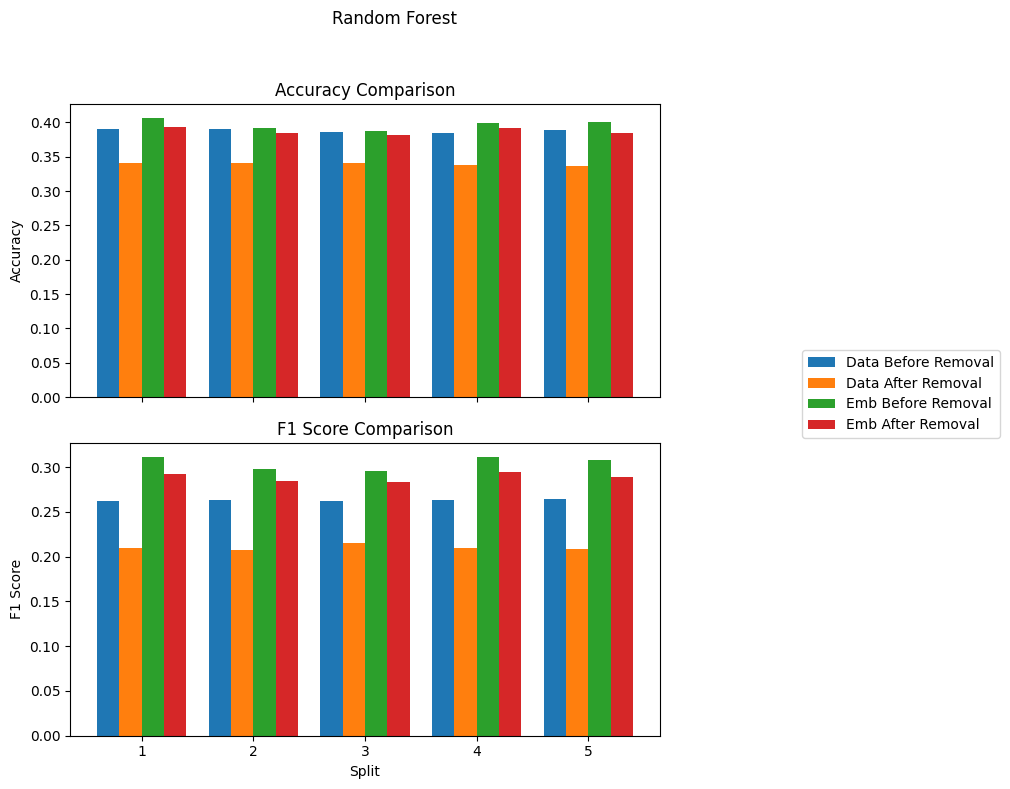

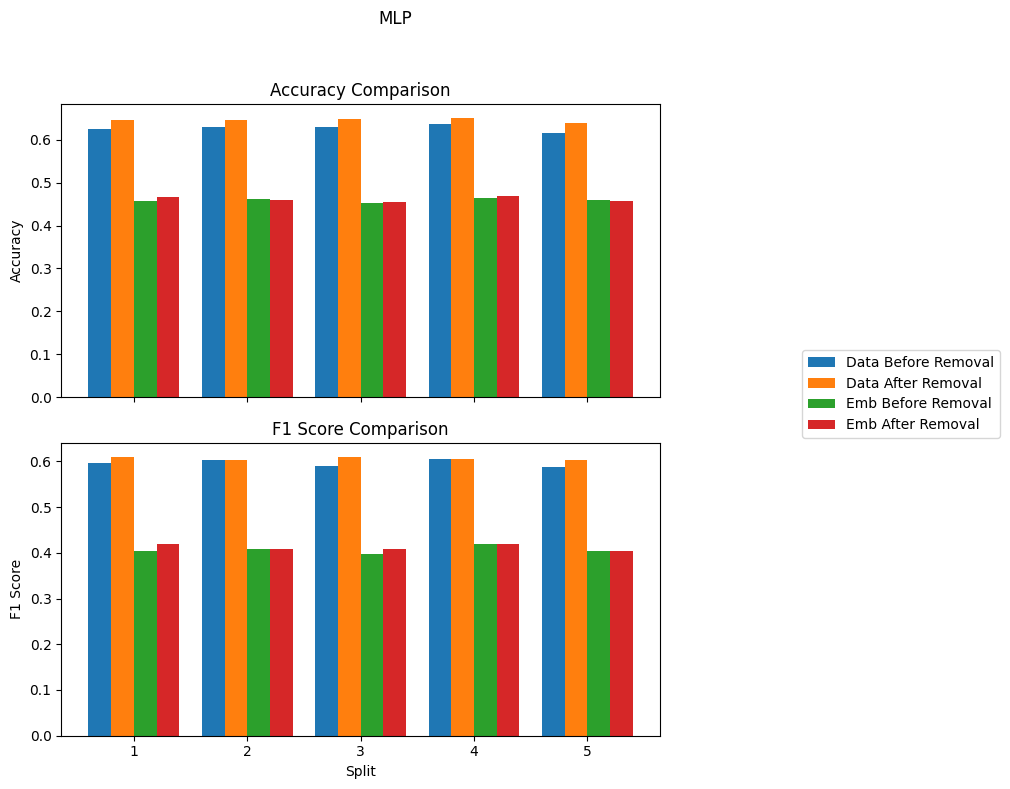

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

data_before = pd.read_csv(f"{output_dir}/random_forest/data/results_before_removal.csv")
data_after = pd.read_csv(f"{output_dir}/random_forest/data/results_after_removal.csv")
emb_before = pd.read_csv(f"{output_dir}/random_forest/emb/results_before_removal.csv")
emb_after = pd.read_csv(f"{output_dir}/random_forest/emb/results_after_removal.csv")

compare_results(data_before, data_after, emb_before, emb_after, "Random Forest")

data_before = pd.read_csv(f"{output_dir}/mlp/data/results_before_removal.csv")
data_after = pd.read_csv(f"{output_dir}/mlp/data/results_after_removal.csv")
emb_before = pd.read_csv(f"{output_dir}/mlp/emb/results_before_removal.csv")
emb_after = pd.read_csv(f"{output_dir}/mlp/emb/results_after_removal.csv")

compare_results(data_before, data_after, emb_before, emb_after, "MLP")


